In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


![title](https://raw.githubusercontent.com/google/eng-edu/main/ml/recommendation-systems/images/softmax-model.png)

In [46]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Datasets

In [6]:
from itertools import cycle, islice

import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

In [7]:
class FashionDatasetSingleLabel(IterableDataset):

    def __init__(self, dataset_filepath, max_length, padding_value):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.max_length = max_length
        
        self.padding_value = padding_value
    
    def process_label(self, label: str):

        return torch.tensor(int(label))
    
    def process_input(self, input_str: str, max_length, padding_value):
        
        input_tensor = torch.tensor([int(v) for v in input_str.split(',')])
        
        len_orig = len(input_tensor)
        
        if len_orig >= max_length:
            
            input_tensor = input_tensor[-max_length:]  # Take latest items
            
        else:
            
            num_pad = max_length - len_orig
            
            input_tensor = F.pad(input_tensor, (0, num_pad), value=padding_value)
            
        return input_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')  # [customer_id, label, input]
            
            label = self.process_label(line_items[1])
            
            input_seq = self.process_input(line_items[2], self.max_length, self.padding_value)

            yield input_seq, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

### fashrec-v1

- Use order history only
- Embedding for each item
- If item ordered X times index its embedding X times
- BoW of all item history embeddings
- For each customer take random transaction and roll-back data

### Train model

In [29]:
total_num_articles = pd.read_csv('data/articles.csv').shape[0]
total_num_articles

105542

In [51]:
class FashionRecV1(nn.Module):

    def __init__(self, mask_value, embedding_dim):
        super(FashionRecV1, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=total_num_articles, embedding_dim=self.embedding_dim)
        
        self.fc_1 = nn.Linear(in_features=self.embedding_dim, out_features=128)
        
        self.fc_2 = nn.Linear(in_features=128, out_features=total_num_articles)
        
        self.relu = nn.ReLU()
        
        self.tanh = nn.Tanh()
        
        self.mask_value = mask_value

    def forward(self, padded_sequences):
        
        x = self.embedding(padded_sequences)

        mask = padded_sequences != self.mask_value
        
        # Repeat mask so that shape matches output of embedding
        mask = torch.unsqueeze(mask, dim=2)
        mask = mask.repeat(1, 1, self.embedding_dim)

        x = mask * x
        
        # Compute average over non-padding embeddings:
        x = x.sum(dim=1)
        num_embeddings = mask[:, :, 0].sum(dim=1).reshape(-1, 1)  # Divide by number of (non-padding) embeddings to get mean embedding

        x = torch.div(
            x, 
            num_embeddings
        )

        x = self.fc_1(x)
        x = self.relu(x)
        
        x = self.fc_2(x)
        x = self.tanh(x)
        
        return x

In [52]:
BATCH_SIZE = 128

In [53]:
total_training_examples = pd.read_csv('data/splits/train_single_purchase_label.tsv', sep='\t', low_memory=False).shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

8325.0

In [54]:
total_dev_examples = pd.read_csv('data/splits/dev_single_purchase_label.tsv', sep='\t', low_memory=False).shape[0]
total_dev_examples

72019

In [55]:
dev_actuals = pd.read_csv('data/splits/dev_all_purchase_label.tsv', sep='\t')['article_id_idx_historical'].str.split(',').apply(lambda x: [int(i) for i in x]).tolist()

In [56]:
PADDING_VALUE = 0

In [57]:
fashion_rec_v1 = FashionRecV1(mask_value=PADDING_VALUE, embedding_dim=1024)

In [58]:
fashion_rec_v1.to(device)

FashionRecV1(
  (embedding): Embedding(105542, 1024)
  (fc_1): Linear(in_features=1024, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=105542, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v1.parameters(), lr=0.003)

In [60]:
BATCH_SIZE_INFERENCE = 512

In [61]:
MAX_EPOCHS = 3

In [62]:
EVAL_BATCH_INTERVAL = 2000

In [63]:
training_losses = []
dev_losses = []
dev_maps = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=50, padding_value=0)    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for idx, data in enumerate(tqdm(train_loader, total=total_batches)):
        
        X, y = data
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v1(X)
        
        loss = criterion(y_pred, y)  # Need index for loss in PyTorch

        loss.backward()    
        
        optimizer.step()
    
        if idx % EVAL_BATCH_INTERVAL == 0:

            # Compute train loss
            train_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=50, padding_value=0)     
            total_train_loss = 0

            with torch.no_grad():
                for data in DataLoader(train_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
                    X, y = data
                    X, y = X.to(device), y.to(device)
                    optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate
                    y_pred = fashion_rec_v1(X)
                    loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
                    total_train_loss += loss

                mean_train_loss = total_train_loss / total_training_examples

                print(f"Training loss: {mean_train_loss}")
                training_losses.append(mean_train_loss)

            # Compute dev loss
            dev_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/dev_single_purchase_label.tsv', max_length=50, padding_value=0)     
            total_dev_loss = 0
            top_12_predictions = []

            with torch.no_grad():
                for data in DataLoader(dev_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
                    X, y = data
                    X, y = X.to(device), y.to(device)
                    optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate
                    y_pred = fashion_rec_v1(X)
                    loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
                    total_dev_loss += loss

                    top_12 = y_pred.argsort(dim=1, descending=True)[:, :12].tolist()
                    top_12_predictions += top_12

                mean_dev_loss = total_dev_loss / total_dev_examples

                print(f"Dev loss: {mean_dev_loss}")
                dev_losses.append(mean_dev_loss)

            # Compute dev MAP@12
            dev_mapk12 = mapk(dev_actuals, top_12_predictions, k=12)
            print(f"Dev MAP@12: {dev_mapk12}")
            dev_maps.append(dev_mapk12)

            time.sleep(5)

    # Compute end of epoch metrics
    train_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/train_single_purchase_label.tsv', max_length=50, padding_value=0)     
    total_train_loss = 0

    with torch.no_grad():
        for data in DataLoader(train_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate
            y_pred = fashion_rec_v1(X)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
            total_train_loss += loss

        mean_train_loss = total_train_loss / total_training_examples

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)

    # Compute dev loss
    dev_dataset_for_loss = FashionDatasetSingleLabel(dataset_filepath='data/splits/dev_single_purchase_label.tsv', max_length=50, padding_value=0)     
    total_dev_loss = 0
    top_12_predictions = []

    with torch.no_grad():
        for data in DataLoader(dev_dataset_for_loss, batch_size=BATCH_SIZE_INFERENCE):
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate
            y_pred = fashion_rec_v1(X)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, y).item()
            total_dev_loss += loss

            top_12 = y_pred.argsort(dim=1, descending=True)[:, :12].tolist()
            top_12_predictions += top_12

        mean_dev_loss = total_dev_loss / total_dev_examples

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)

    # Compute dev MAP@12
    dev_mapk12 = mapk(dev_actuals, top_12_predictions, k=12)
    print(f"Dev MAP@12: {dev_mapk12}")
    dev_maps.append(dev_mapk12)

    time.sleep(5)

  0%|          | 0/8325.0 [00:00<?, ?it/s]

Training loss: 11.577462074673283
Dev loss: 11.574672721591915
Dev MAP@12: 0.00011107897487335055


 24%|██▍       | 1999/8325.0 [03:20<06:03, 17.38it/s]

Training loss: 11.074724538118579
Dev loss: 11.30593302093024
Dev MAP@12: 0.005566141232307129


 48%|████▊     | 4000/8325.0 [06:30<04:08, 17.38it/s]

Training loss: 10.96326641732369
Dev loss: 11.275202669363944
Dev MAP@12: 0.005797435619844084


 72%|███████▏  | 6000/8325.0 [09:30<02:13, 17.41it/s]

Training loss: 10.912966815821873
Dev loss: 11.266696297971281
Dev MAP@12: 0.006030992103203672


 96%|█████████▌| 8000/8325.0 [12:40<00:18, 17.40it/s]

Training loss: 10.888702733468326
Dev loss: 11.267655120876306
Dev MAP@12: 0.00625439399729812


100%|██████████| 8325/8325.0 [13:54<00:00,  9.97it/s]


Training loss: 10.887965443181734
Dev loss: 11.268871925561744
Dev MAP@12: 0.006218502194094915


  0%|          | 0/8325.0 [00:00<?, ?it/s]

Training loss: 10.887965081612425
Dev loss: 11.268875271439871
Dev MAP@12: 0.006218502194094915


 24%|██▍       | 1999/8325.0 [03:24<06:03, 17.41it/s]

Training loss: 10.878171333313954
Dev loss: 11.271514009920558
Dev MAP@12: 0.006158974631541005


 48%|████▊     | 4000/8325.0 [06:24<04:08, 17.42it/s]

Training loss: 10.874465831841245
Dev loss: 11.277077289961026
Dev MAP@12: 0.0061764657140337825


 72%|███████▏  | 6000/8325.0 [09:34<02:13, 17.43it/s]

Training loss: 10.871374709716898
Dev loss: 11.282026040328768
Dev MAP@12: 0.00616548527046784


 96%|█████████▌| 8000/8325.0 [12:34<00:18, 17.42it/s]

Training loss: 10.869174912791683
Dev loss: 11.28555427728924
Dev MAP@12: 0.0061760217714299


100%|██████████| 8325/8325.0 [13:53<00:00,  9.98it/s]


Training loss: 10.869035429984088
Dev loss: 11.285708319891063
Dev MAP@12: 0.006181572972741943


  0%|          | 0/8325.0 [00:00<?, ?it/s]

Training loss: 10.869032458150162
Dev loss: 11.285704960453144
Dev MAP@12: 0.006181572972741943


 24%|██▍       | 1999/8325.0 [03:19<06:03, 17.40it/s]

Training loss: 10.870663723454305
Dev loss: 11.290014773526561
Dev MAP@12: 0.021531209084780806


 48%|████▊     | 4000/8325.0 [06:29<04:08, 17.41it/s]

Training loss: 10.868205721104298
Dev loss: 11.292542796323714
Dev MAP@12: 0.025916983179183943


 72%|███████▏  | 6000/8325.0 [09:29<02:13, 17.40it/s]

Training loss: 10.868316163285964
Dev loss: 11.29398659189003
Dev MAP@12: 0.02919344460038736


 96%|█████████▌| 8000/8325.0 [12:39<00:18, 17.42it/s]

Training loss: 10.869828905088076
Dev loss: 11.29610445477604
Dev MAP@12: 0.03370363057191232


100%|██████████| 8325/8325.0 [13:53<00:00,  9.99it/s]


Training loss: 10.86925959565191
Dev loss: 11.296010346445035
Dev MAP@12: 0.033704370624669897


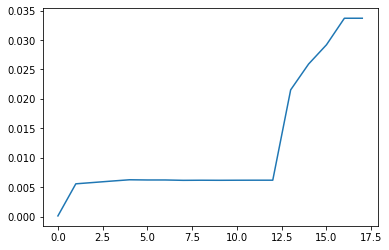

In [64]:
plt.plot(dev_maps)

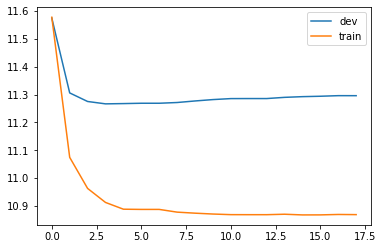

In [67]:
plt.plot(dev_losses, label='dev')
plt.plot(training_losses, label='train')
plt.legend()
plt.show()

TODO
- Add shuffle to datasets (or pre-shuffle)
- Add to_device and check that it's GPU
- Add code for generating predictions for submission